In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats

In [2]:
store_data = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

D:\EduPr\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**Some info about our features**

<li>Id - an Id that represents a (Store, Date) duple within the test set</li>
<li>Store - a unique Id for each store</li>
<li>Sales - the turnover for any given day (this is what you are predicting)</li>
<li>Customers - the number of customers on a given day</li>
<li>Open - an indicator for whether the store was open: 0 = closed, 1 = open</li>
<li>StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None</li>
<li>SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools</li>
<li>StoreType - differentiates between 4 different store models: a, b, c, d</li>
<li>Assortment - describes an assortment level: a = basic, b = extra, c = extended</li>
<li>CompetitionDistance - distance in meters to the nearest competitor store</li>
<li>CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened</li>
<li>Promo - indicates whether a store is running a promo on that day</li>
<li>Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating</li>
<li>Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2</li>
<li>PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store</li>

In [3]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
store_data.shape

(1115, 10)

In [5]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
train_data.shape

(1017209, 9)

In [7]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [8]:
test_data.shape

(41088, 8)

Как видно, отсутствует не только предсказываемый признак Sales, но и Customers (что, в целом, довольно логично), поэтому его в модель включать не будем

### Разберемся со store_data

In [9]:
store_data.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [10]:
obj_cols_store = []
for col in store_data.columns:
    if store_data[col].dtype == 'object':
        obj_cols_store.append(col)
num_cols_store = list(set(store_data.columns) - set(obj_cols_store))

In [11]:
store_data[num_cols_store].describe()

,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,CompetitionDistance,Promo2SinceYear,Store,CompetitionOpenSinceMonth
count,761.000000,1115.000000,571.000000,1112.000000,571.000000,1115.00000,761.000000
mean,2008.668857,0.512108,23.595447,5404.901079,2011.763573,558.00000,7.224704
std,6.195983,0.500078,14.141984,7663.174720,1.674935,322.01708,3.212348
min,1900.000000,0.000000,1.000000,20.000000,2009.000000,1.00000,1.000000
25%,2006.000000,0.000000,13.000000,717.500000,2011.000000,279.50000,4.000000
50%,2010.000000,1.000000,22.000000,2325.000000,2012.000000,558.00000,8.000000
75%,2013.000000,1.000000,37.000000,6882.500000,2013.000000,836.50000,10.000000
max,2015.000000,1.000000,50.000000,75860.000000,2015.000000,1115.00000,12.000000


In [12]:
store_data[obj_cols_store].describe()

,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


**Пропуски**

In [13]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [14]:
next_year = np.max(pd.to_datetime(train_data['Date']).dt.year) + 1

In [15]:
store_data['PromoInterval'].fillna('No', inplace=True)
store_data['Promo2SinceWeek'].fillna(0, inplace=True)
store_data['Promo2SinceYear'].fillna(next_year, inplace=True)

In [16]:
store_data['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
store_data['CompetitionOpenSinceYear'].fillna(next_year, inplace=True)
store_data['CompetitionDistance'].fillna(np.max(store_data['CompetitionDistance']), inplace=True)             

In [17]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,2016.0,No
4,5,a,a,29910.0,4.0,2015.0,0,0.0,2016.0,No


### Теперь train_data

In [18]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [19]:
train_data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [20]:
obj_cols_train = ['Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
num_cols_train = list(set(train_data.columns) - set(obj_cols_train))

In [21]:
train_data[num_cols_train].describe()

,Customers,DayOfWeek,Store,Sales
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,6.331459e+02,3.998341e+00,5.584297e+02,5.773819e+03
std,4.644117e+02,1.997391e+00,3.219087e+02,3.849926e+03
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,4.050000e+02,2.000000e+00,2.800000e+02,3.727000e+03
50%,6.090000e+02,4.000000e+00,5.580000e+02,5.744000e+03
75%,8.370000e+02,6.000000e+00,8.380000e+02,7.856000e+03
max,7.388000e+03,7.000000e+00,1.115000e+03,4.155100e+04


In [22]:
train_data[obj_cols_train].astype('object').describe()

,Open,Promo,StateHoliday,SchoolHoliday
count,1017209,1017209,1017209,1017209
unique,2,2,5,2
top,1,0,0,0
freq,844392,629129,855087,835488


In [23]:
train_data[obj_cols_train] = train_data[obj_cols_train].astype('object')
train_data[obj_cols_train].describe()

,Open,Promo,StateHoliday,SchoolHoliday
count,1017209,1017209,1017209,1017209
unique,2,2,5,2
top,1,0,0,0
freq,844392,629129,855087,835488


In [24]:
train_data.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

**Соединяем информацию о магазинах с тестовым датафреймом**

In [25]:
data = train_data.merge(store_data, how='inner', on='Store')

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  object 
 6   Promo                      1017209 non-null  object 
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  object 
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

## EDA

In [27]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,2016.0,No


In [28]:
data['Date'] = pd.to_datetime(data['Date'])

In [29]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['DayOfMonth'] = data.Date.dt.day
data['WeekOfYear'] = data.Date.dt.isocalendar().week

Также можно рассчитать количество месяцев, которое прошло между моментами введения промо и открытия ближайшего конкурента; введения промо и текущим днем (на момент наблюдения);

In [30]:
data['Current-OpenComp'] = 12 * (data['Year'] - data['CompetitionOpenSinceYear']) \
                            + (data['Month'] - data['CompetitionOpenSinceMonth'])
data['Current-OpenPromo'] = 12 * (data['Year'] - data['Promo2SinceYear']) \
                            + (data['Month'] - data['Promo2SinceWeek'] * 12 / 52)

In [31]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,DayOfMonth,WeekOfYear,Current-OpenComp,Current-OpenPromo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0.0,2016.0,No,2015,7,31,31,82.0,-5.0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,0.0,2016.0,No,2015,7,30,31,82.0,-5.0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,0.0,2016.0,No,2015,7,29,31,82.0,-5.0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,0.0,2016.0,No,2015,7,28,31,82.0,-5.0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,0.0,2016.0,No,2015,7,27,31,82.0,-5.0


Посмотрим на распределение целевого признака при Open == 0 (если магазин закрыт, продаж быть не должно)

In [32]:
data[data["Open"] == 0].Sales.unique()[0]

0

Видим, что при Open == 0 продаж нет, так что от него можно избавиться

In [33]:
data = data[data["Open"] == 1].copy()

In [34]:
data.drop(['Open', 'Customers'], axis=1, inplace=True)

In [35]:
data.apply(lambda x: x.nunique())

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21734
Promo                            2
StateHoliday                     5
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       13
CompetitionOpenSinceYear        24
Promo2                           2
Promo2SinceWeek                 25
Promo2SinceYear                  8
PromoInterval                    4
Year                             3
Month                           12
DayOfMonth                      31
WeekOfYear                      52
Current-OpenComp               371
Current-OpenPromo              605
dtype: int64

In [36]:
num_cols = ['Store', 'CompetitionDistance', 'Promo2SinceWeek', 'DayOfMonth',
            'WeekOfYear', 'Current-OpenComp', 'Current-OpenPromo']
disc_cols = ['DayOfWeek', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Month']
obj_cols = list(set(data.columns) - set(num_cols) - set(disc_cols) - set(['Sales']))
target = data['Sales']

In [37]:
data[num_cols] = data[num_cols].astype('float64')
data[disc_cols] = data[disc_cols].astype('int64')
data[obj_cols] = data[obj_cols].astype('object')

Изучим целевую переменную и ее взаимодействия с признаками

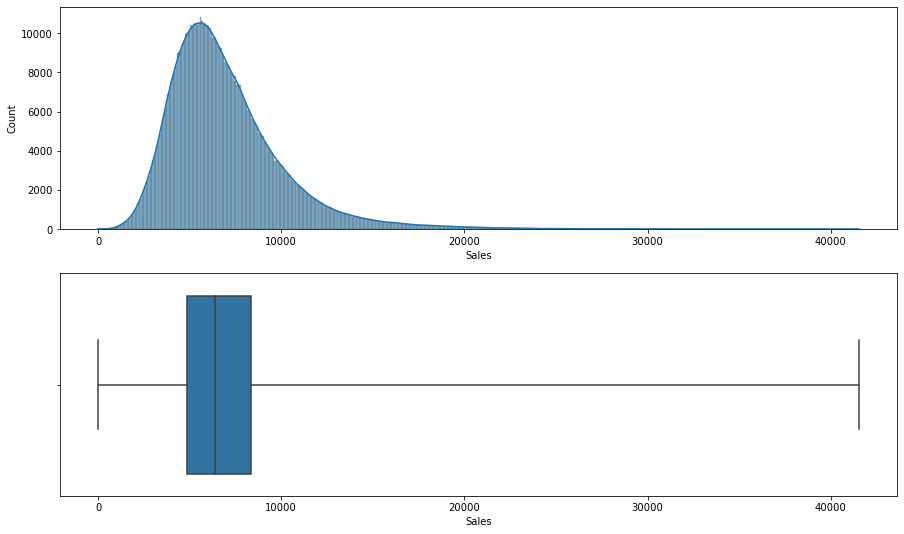

In [38]:
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# hist of target
sns.histplot(target, kde=True, ax=axes[0]);

# max, min, mean, 0.25 to 0.75 quantiles
sns.boxplot(x=target, whis=np.inf, ax=axes[1]);

In [39]:
def kde_feature(data, target_col, obj_col):
    if data[obj_col].nunique() == 2:
        unique_values = data[obj_col].unique()
        data_subset = data[[target_col, obj_col]]
        tar1, tar2 = data_subset[data_subset['Promo'] == unique_values[0]], \
                     data_subset[data_subset['Promo'] == unique_values[1]]
        
        stat, p_value = stats.ttest_ind(tar1[target_col], tar2[target_col])
        print('Calculated t-statistic: ', stat)
        print('P-value: ', p_value)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # kernel density estimate for every month
    sns.kdeplot(data=data, x=target_col, hue=obj_col, ax=axes[0]);
    # distribution of months
    sns.countplot(data=data, x=obj_col, ax=axes[1])

    axes[0].set_title(f'KDE of {target_col}')
    axes[1].set_title(f'"{obj_col}" distribution')

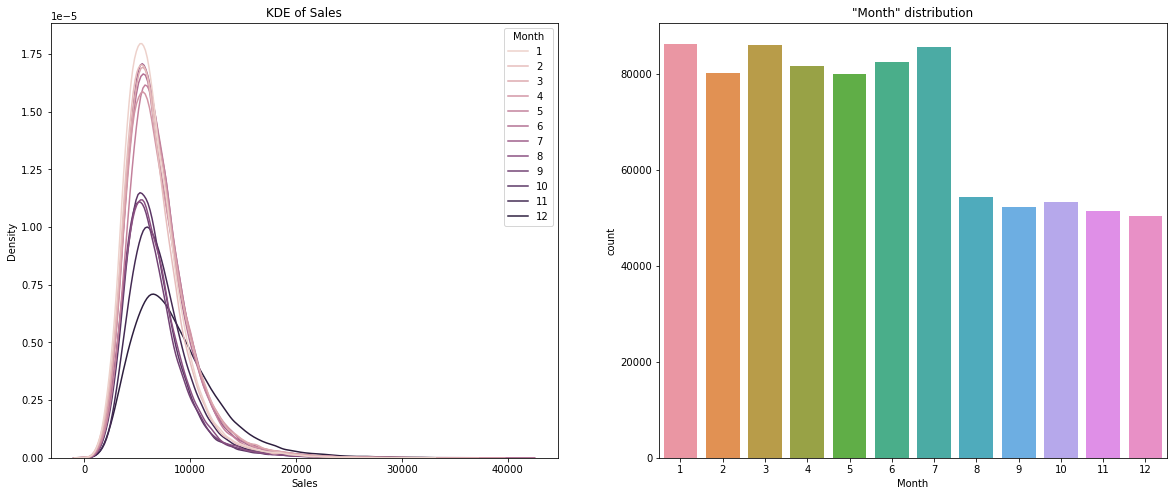

In [40]:
kde_feature(data, 'Sales', 'Month')

Calculated t-statistic:  363.8446754265649
P-value:  0.0


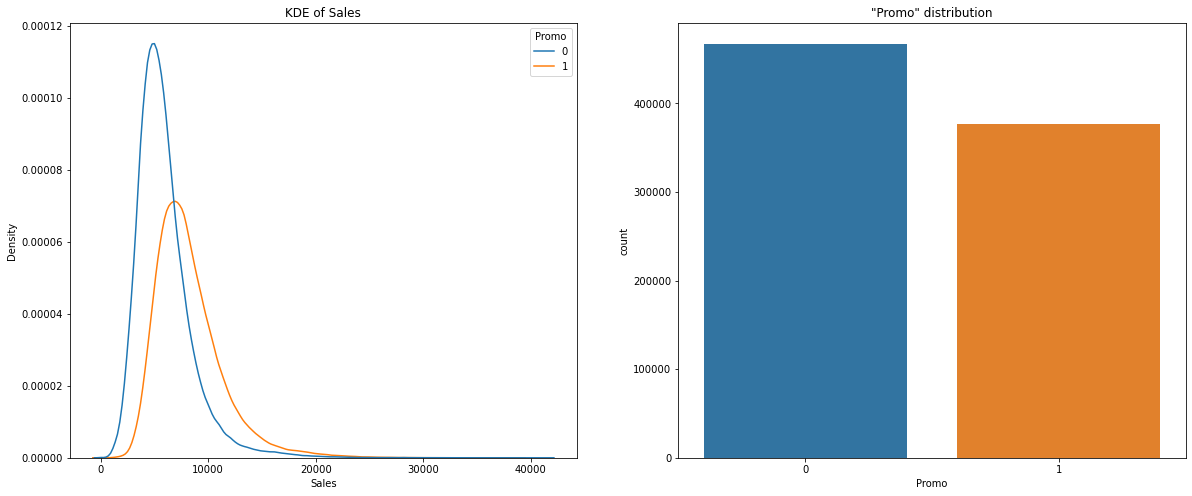

In [41]:
kde_feature(data, 'Sales', 'Promo')

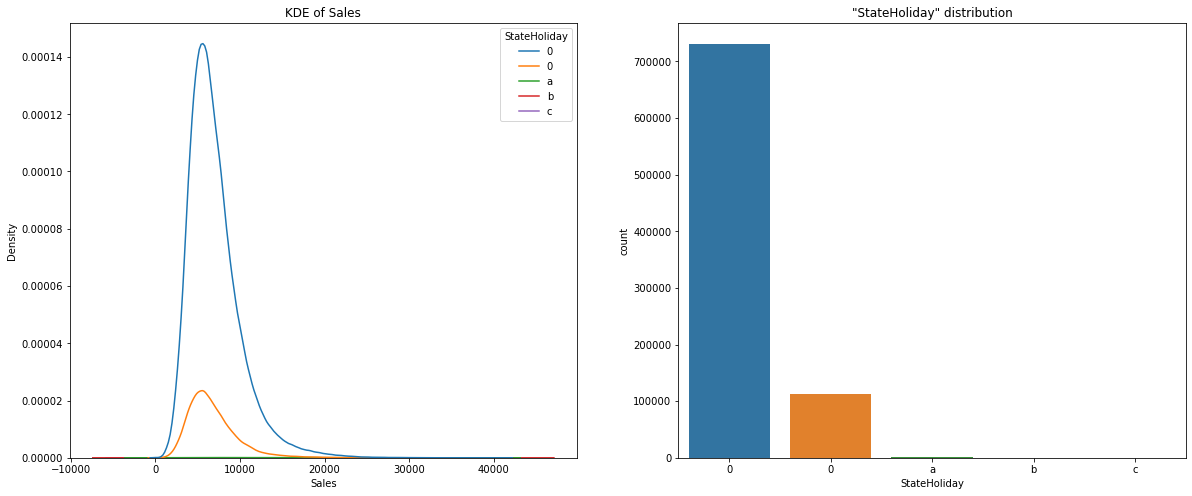

In [42]:
kde_feature(data, 'Sales', 'StateHoliday')

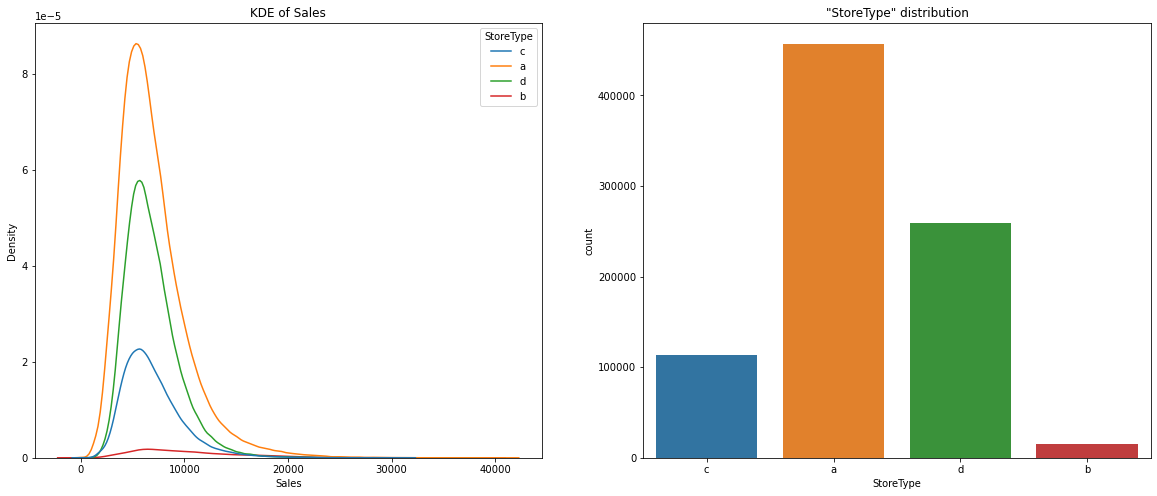

In [43]:
kde_feature(data, 'Sales', 'StoreType')

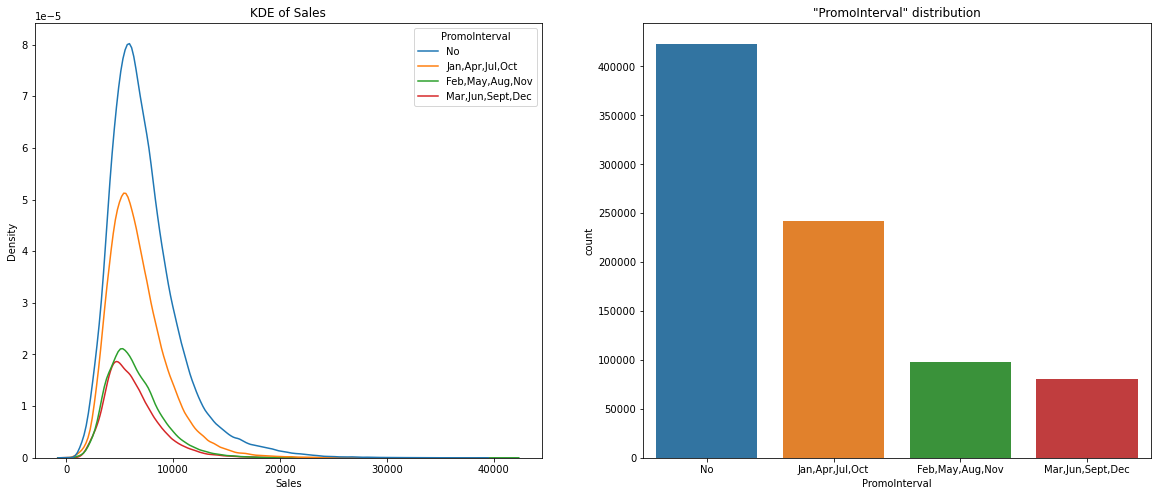

In [44]:
kde_feature(data, 'Sales', 'PromoInterval')

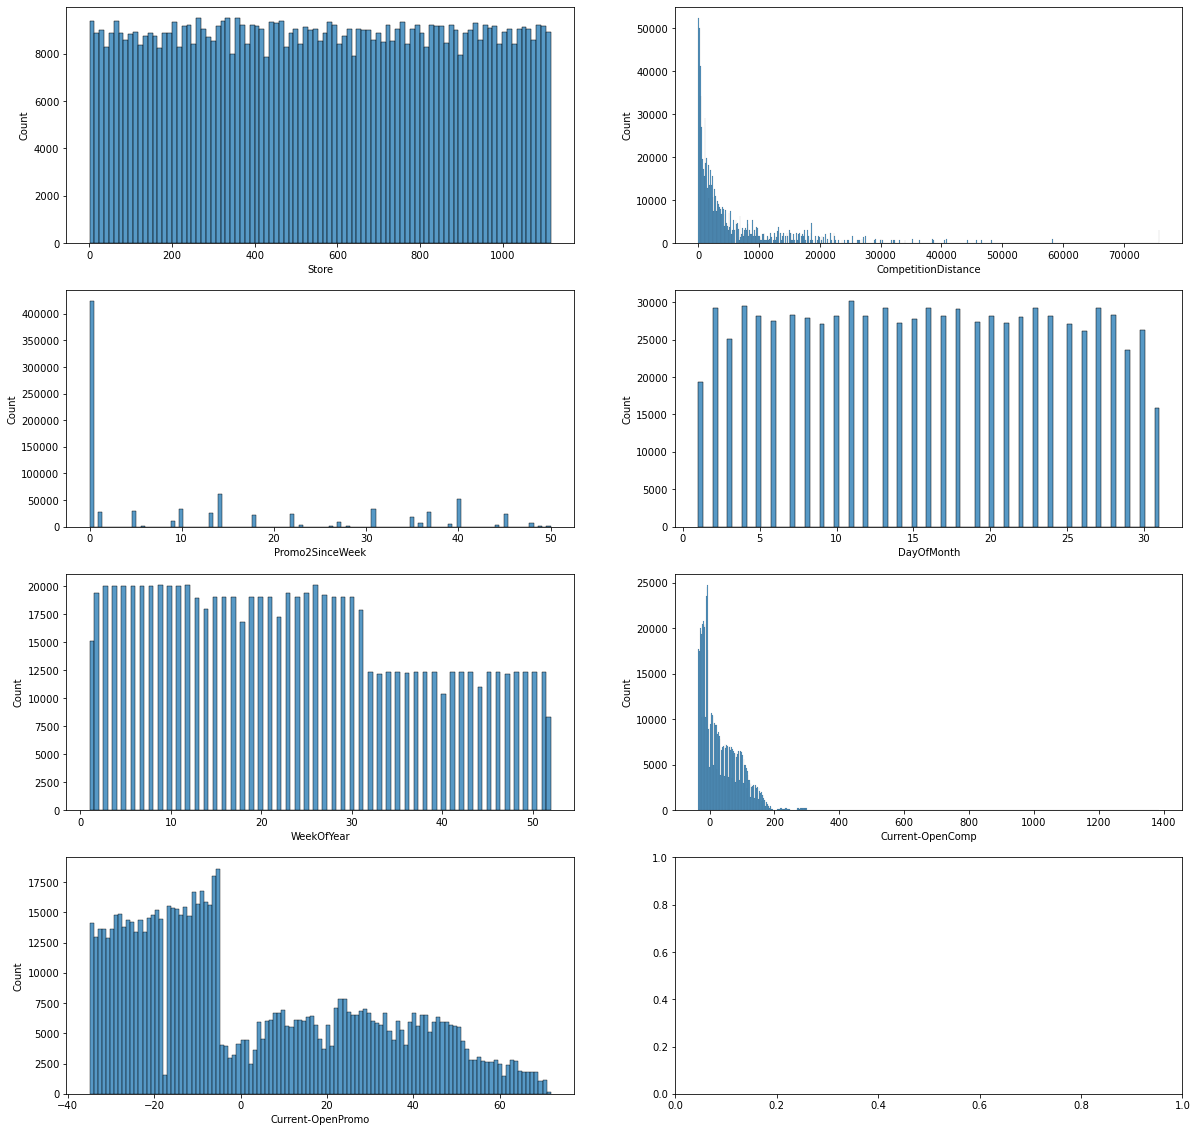

In [45]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
for i, col in enumerate(num_cols):
    sns.histplot(data = data[num_cols], x = col, ax=axes[i // 2, i % 2])